# pypfopt test

In [141]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Read in price data
df = pd.read_csv("data/stock_prices.csv", parse_dates=True, index_col="date")

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict({'GOOG': 0.03835, 'AAPL': 0.0689, 'FB': 0.20603, 'BABA': 0.07315, 'AMZN': 0.04033, 'GE': 0.0, 'AMD': 0.0, 'WMT': 0.0, 'BAC': 0.0, 'GM': 0.0, 'T': 0.0, 'UAA': 0.0, 'SHLD': 0.0, 'XOM': 0.0, 'RRC': 0.0, 'BBY': 0.01324, 'MA': 0.35349, 'PFE': 0.1957, 'JPM': 0.0, 'SBUX': 0.01082})
Expected annual return: 30.5%
Annual volatility: 22.2%
Sharpe Ratio: 1.28


(0.3047768672819918, 0.22165566922402968, 1.2847714127003216)

In [6]:
weights = raw_weights

In [7]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(df)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'MA': 20, 'FB': 12, 'PFE': 54, 'BABA': 4, 'AAPL': 4, 'GOOG': 1, 'BBY': 2, 'SBUX': 1}
Funds remaining: $11.89


# quantstats test

In [1]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

[*********************100%%**********************]  1 of 1 completed


0.7300915190465034

In [2]:
stock

Date
2012-05-18         NaN
2012-05-21   -0.109861
2012-05-22   -0.089039
2012-05-23    0.032258
2012-05-24    0.032187
                ...   
2024-05-30   -0.015410
2024-05-31   -0.000471
2024-06-03    0.022835
2024-06-04   -0.001047
2024-06-05    0.037883
Name: Close, Length: 3031, dtype: float64

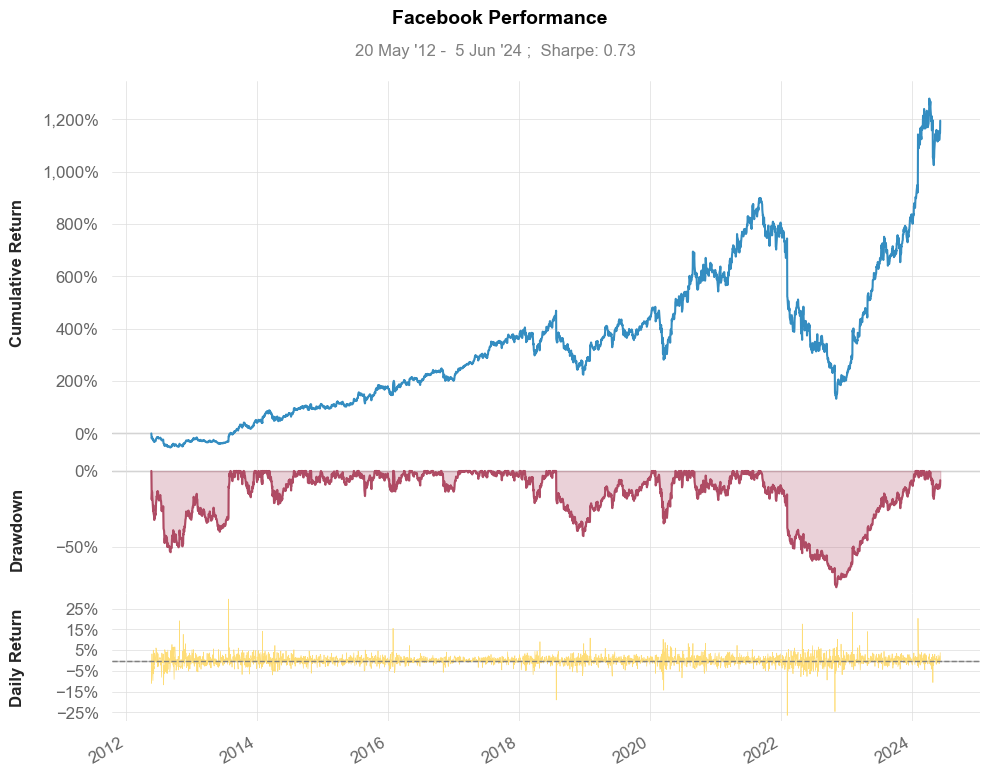

In [3]:
qs.plots.snapshot(stock, title='Facebook Performance', show=True)

# can also be called via:
# stock.plot_snapshot(title='Facebook Performance', show=True)

# bt

In [1]:
import bt
import FinanceDataReader as fdr

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams["font.family"] = 'NanumBarunGothic'

In [39]:
def buy_and_hold(data, name):
    strategy = bt.Strategy(name, [
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(strategy, data)

## simple k all weather

### data

In [4]:
etfs = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

In [5]:
#cond = etfs.Name.str.contains('KODEX') & etfs.Name.str.contains('S&P')
#cond = etfs.Name.str.contains('ACE KRX')
cond = etfs.Name.str.contains('미국채혼합')
etfs.loc[cond]

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
244,284430,6,KODEX 200미국채혼합,13010,2,60,0.46,12981.0,2.8052,41313,537,770


In [6]:
symbols = ['379800', '411060', '284430']
etfs.loc[etfs.Symbol.isin(symbols), 'Name']

20     KODEX 미국S&P500TR
122          ACE KRX금현물
244      KODEX 200미국채혼합
Name: Name, dtype: object

In [7]:
names = etfs.loc[etfs.Symbol.isin(symbols), 'Name'].to_list()

In [8]:
df = fdr.DataReader(','.join(symbols), '2010')
df = df.rename(columns=dict(zip(symbols, names)))

<Axes: xlabel='Date'>

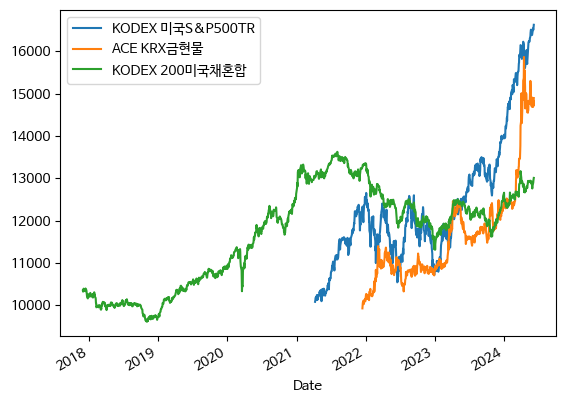

In [9]:
df.plot()

In [10]:
df.dropna()

,KODEX 미국S&P500TR,ACE KRX금현물,KODEX 200미국채혼합
Date,,,
2021-12-15,12145.0,9930.0,13270
2021-12-16,12335.0,9990.0,13295
2021-12-17,12150.0,10060.0,13320
2021-12-20,11965.0,10110.0,13305
2021-12-21,12115.0,10060.0,13320
...,...,...,...
2024-05-31,16455.0,14905.0,12830
2024-06-03,16540.0,14685.0,12885
2024-06-04,16500.0,14835.0,12895


In [11]:
data = df.dropna()

### compare

In [12]:
strategy = bt.Strategy('Asset_EW', [
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])
bt1 = bt.Backtest(strategy, data)

In [25]:
wts = [0.3, 0.2, 0.5]

strategy = bt.Strategy('Asset_SAW', [
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(**dict(zip(data.columns, wts))),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])
bt2 =  bt.Backtest(strategy, data)

bt3 =  bt.Backtest(strategy, data,
                  name='SAW_net', commissions=lambda q, p: abs(q*p*0.002))

In [90]:
from pandas.tseries.offsets import DateOffset

start = data.index[0]
df_kospi = fdr.DataReader('KS11', start+DateOffset(years=-1)).Close.to_frame('KOSPI')

In [91]:
bt0 = buy_and_hold(df_kospi.loc[df_kospi.index >= start], 'KOSPI')

In [98]:
results = bt.run(bt0, bt1, bt2, bt3)

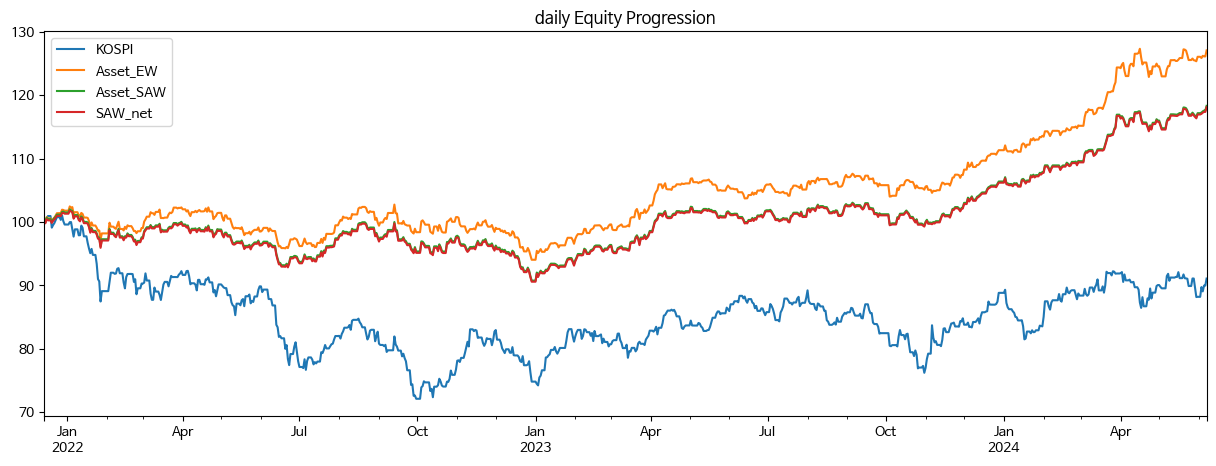

In [99]:
results.plot(freq='d');

In [100]:
#results.display()
results.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,KOSPI,Asset_EW,Asset_SAW,SAW_net
total_return,-0.089084,0.27044,0.18308,0.181022
cagr,-0.036917,0.101308,0.070127,0.069376
daily_vol,0.169245,0.079536,0.075156,0.07525
max_drawdown,-0.285881,-0.084614,-0.110115,-0.110048
calmar,-0.129134,1.197293,0.63685,0.630416
daily_sharpe,-0.143646,1.285232,0.963265,0.952571


<Axes: >

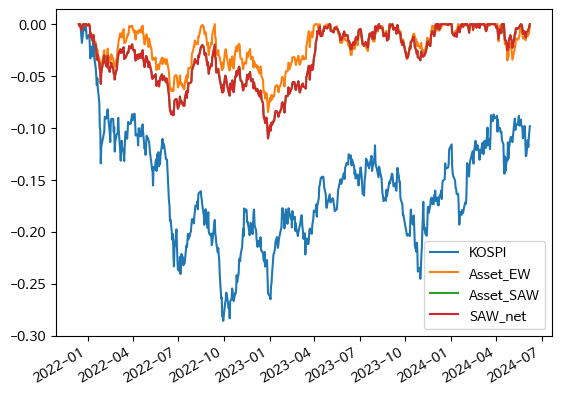

In [101]:
results.prices.rebase().to_drawdown_series().plot()

## KOSPI

In [102]:
df_kospi = fdr.DataReader('KS11').Close.to_frame('KOSPI')
df_kospi.head()

,KOSPI
Date,
2001-06-11,608.23
2001-06-12,607.15
2001-06-13,614.05
2001-06-14,613.75
2001-06-15,618.96


In [103]:
bt0 = buy_and_hold(df_kospi, 'KOSPI')

In [104]:
df_kospi_sma = df_kospi.rolling(200).mean()

strategy = bt.Strategy('Timing_KOSPI', [
    bt.algos.SelectWhere(df_kospi > df_kospi_sma),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
bt1 =  bt.Backtest(strategy, df_kospi)

In [108]:
sma_200 = df_kospi_sma.copy()
sma_60 = df_kospi.rolling(60).mean()
df_signal = sma_200.copy()
df_signal[sma_60 >= sma_200] = 1
df_signal[sma_60 < sma_200] = -1
df_signal[df_signal.isnull()] = 0

strategy = bt.Strategy('SMA_crossover', [
    bt.algos.SelectAll(),
    bt.algos.WeighTarget(df_signal),
    bt.algos.Rebalance()
])
bt2 =  bt.Backtest(strategy, df_kospi)

In [138]:
def SMA(data,period = 30, column = 'Close') :
    return data[column].rolling(window = period).mean()
    

def RSI(data, period = 14, column = 'Close') :
    delta = data[column].diff(1)
    delta = delta.dropna()
    
    up = delta.copy()
    down = delta.copy()
    up[up <0] =0
    down[down>0] = 0
    data['up'] = up
    data['down'] = down
    
    AVG_Gain = SMA(data, period, column = 'up')
    AVG_Loss = abs(SMA(data,period,column = 'down'))
    RS = AVG_Gain / AVG_Loss
    
    RSI = 100.0 - (100.0 / (1.0+RS))
    data['RSI'] = RSI
    
    return data


df_rsi = RSI(df_kospi, column='KOSPI')
signal = df_rsi['RSI']
sell = df_rsi['RSI'] > 70
buy = df_rsi['RSI'] < 30
signal[sell] = -1
signal[buy] = 1
signal[~sell & ~buy] = 0
signal[signal.isnull()] = 0
signal = signal.to_frame()

strategy = bt.Strategy('RSI_MeanReversion', [
    bt.algos.SelectAll(),
    bt.algos.WeighTarget(signal),
    bt.algos.Rebalance()
])
bt3 =  bt.Backtest(strategy, df_kospi)

In [139]:
df_rsi.loc['2001-07']

,KOSPI,up,down,RSI
Date,,,,
2001-07-02,596.74,1.61,0.00,0.0
2001-07-03,594.31,0.00,-2.43,0.0
2001-07-04,597.25,2.94,0.00,0.0
2001-07-05,593.61,0.00,-3.64,0.0
2001-07-06,578.54,0.00,-15.07,1.0
2001-07-09,560.00,0.00,-18.54,1.0
2001-07-10,558.60,0.00,-1.40,1.0
2001-07-11,553.65,0.00,-4.95,1.0
2001-07-12,559.95,6.30,0.00,1.0


In [140]:
results = bt.run(bt0, bt1, bt2, bt3)

ZeroDivisionError: Could not update RSI_MeanReversion on 2001-07-20 00:00:00. Last value was 0.0 and net flows were 0. Currentvalue is 1000000.0. Therefore, we are dividing by zero to obtain the return for the period.

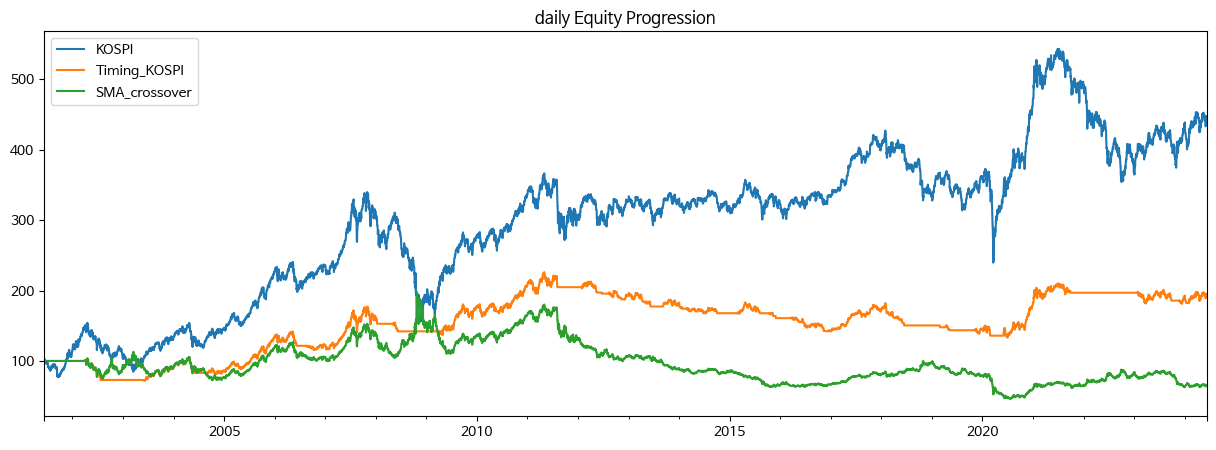

In [127]:
results.plot(freq='d');

In [107]:
results.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,KOSPI,Timing_KOSPI
total_return,3.476139,0.953641
cagr,0.067356,0.029555
daily_vol,0.209884,0.129417
max_drawdown,-0.545355,-0.411333
calmar,0.123509,0.071852
daily_sharpe,0.42209,0.294487


# Simple k all weather

## Setting

In [1]:
import bt
import FinanceDataReader as fdr

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams["font.family"] = 'NanumBarunGothic'

In [3]:
def buy_and_hold(data, name):
    strategy = bt.Strategy(name, [
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(strategy, data)

## Data

In [4]:
etfs = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

In [5]:
#cond = etfs.Name.str.contains('KODEX') & etfs.Name.str.contains('S&P')
#cond = etfs.Name.str.contains('ACE KRX')
cond = etfs.Name.str.contains('미국채혼합')
etfs.loc[cond]

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
244,284430,6,KODEX 200미국채혼합,13010,2,60,0.46,12981.0,2.8052,41313,537,770


In [58]:
symbols = ['379800', '411060', '284430']
etfs.loc[etfs.Symbol.isin(symbols), ['Symbol','Name']]

,Symbol,Name
20,379800,KODEX 미국S&P500TR
122,411060,ACE KRX금현물
244,284430,KODEX 200미국채혼합


In [7]:
names = etfs.loc[etfs.Symbol.isin(symbols), 'Name'].to_list()

In [8]:
df = fdr.DataReader(','.join(symbols), '2010')
df = df.rename(columns=dict(zip(symbols, names)))

<Axes: xlabel='Date'>

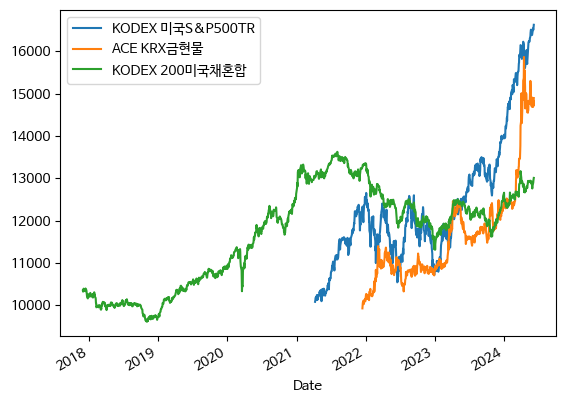

In [9]:
df.plot()

In [11]:
df_skaw = df.dropna()
start = df_skaw.index[0]

## Distribution

### BM - KOSPI

In [17]:
from pandas.tseries.offsets import DateOffset

df_kospi = fdr.DataReader('KS11', start).Close.to_frame('KOSPI')
bt0 = buy_and_hold(df_kospi, 'KOSPI')

### Equal weights

In [12]:
strategy = bt.Strategy('Equal', [
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])
bt1 = bt.Backtest(strategy, df_skaw)

### K All Weather

In [27]:
wts = [0.3, 0.2, 0.5]
wts = dict(zip(df_skaw.columns, wts))

strategy = bt.Strategy('K All-weather', [
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(**wts),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])
bt2 =  bt.Backtest(strategy, df_skaw)
wts

{'KODEX 미국S&P500TR': 0.3, 'ACE KRX금현물': 0.2, 'KODEX 200미국채혼합': 0.5}

### Optimization

In [23]:
df = df_skaw

In [26]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

_ = ef.portfolio_performance(verbose=True)

OrderedDict({'KODEX 미국S&P500TR': 0.37426, 'ACE KRX금현물': 0.62574, 'KODEX 200미국채혼합': 0.0})
Expected annual return: 16.7%
Annual volatility: 10.2%
Sharpe Ratio: 1.44


In [29]:
wts = cleaned_weights

strategy = bt.Strategy('MVO', [
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(**wts),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])
bt3 =  bt.Backtest(strategy, df_skaw)
wts

OrderedDict([('KODEX 미국S&P500TR', 0.37426),
             ('ACE KRX금현물', 0.62574),
             ('KODEX 200미국채혼합', 0.0)])

## Result

In [30]:
results = bt.run(bt0, bt1, bt2, bt3)

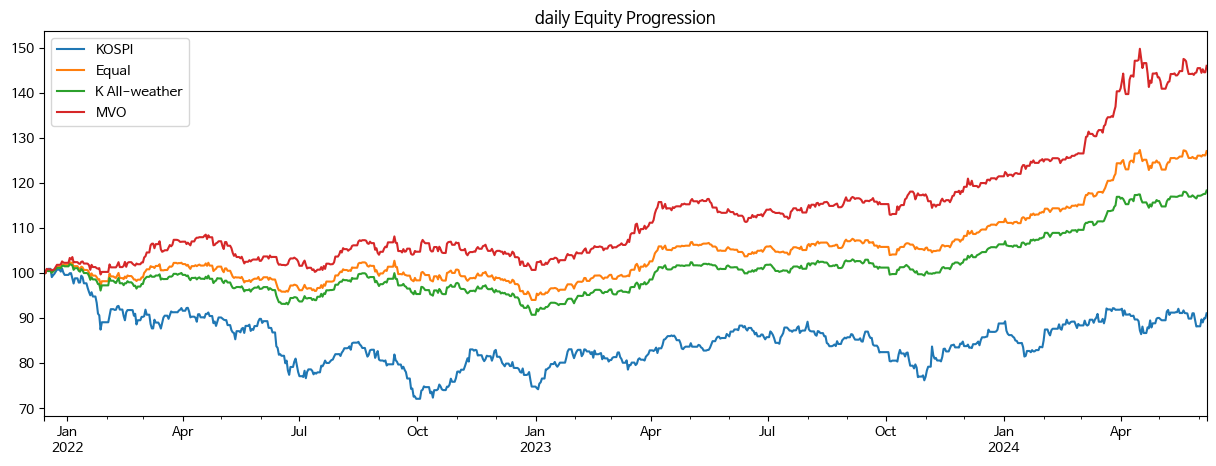

In [31]:
results.plot(freq='d');

In [32]:
results.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,KOSPI,Equal,K All-weather,MVO
total_return,-0.089084,0.27044,0.18308,0.45959
cagr,-0.036917,0.101308,0.070127,0.164686
daily_vol,0.169245,0.079536,0.075156,0.101041
max_drawdown,-0.285881,-0.084614,-0.110115,-0.076052
calmar,-0.129134,1.197293,0.63685,2.165443
daily_sharpe,-0.143646,1.285232,0.963265,1.599545


# ETF

## Setting

In [110]:
import bt
import FinanceDataReader as fdr
import pandas as pd

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams["font.family"] = 'NanumBarunGothic'

In [113]:
def buy_and_hold(df, name):
    if isinstance(df, pd.Series):
        df = df.to_frame('name')
        
    strategy = bt.Strategy(name, [
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(strategy, df)

## Data

In [43]:
df_etf = fdr.StockListing('ETF/KR') # 한국 ETF 전종목
df_etf.head()

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
0,459580,6,KODEX CD금리액티브(합성),1038395,2,320,0.03,1038390.0,0.9095,410287,426038,90027
1,357870,6,TIGER CD금리투자KIS(합성),54430,2,5,0.01,54427.0,0.8897,234090,12740,72887
2,069500,1,KODEX 200,37240,2,485,1.32,37299.0,4.8334,2968765,110370,63662
3,423160,6,KODEX KOFR금리액티브(합성),107025,2,35,0.03,107005.0,0.9146,37907,4056,52420
4,449170,6,TIGER KOFR금리액티브(합성),105545,2,5,0.00,105552.0,0.9082,38193,4031,36980


In [85]:
cond = df_etf.Name.str.contains('채권')
cond = cond | df_etf.Name.str.contains('국고채')
cond = cond | df_etf.Name.str.contains('국채')
#cond = cond & df_etf.Name.str.contains('미국')
cond = cond & ~df_etf.Name.str.contains('액티브')

#cond = df_etf.Name.str.contains('S&P')

#cond = df_etf.Name.str.contains('금현물')

df_etf.loc[cond].sort_values('MarCap', ascending=False)

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
21,214980,6,KODEX 단기채권PLUS,110795,2,25,0.02,110785.0,0.9153,13622,1509,12848
44,153130,6,KODEX 단기채권,109855,2,10,0.01,109853.0,0.8537,21790,2393,7373
64,148070,6,KOSEF 국고채10년,112610,2,410,0.37,112573.0,1.2270,9711,1091,4932
73,385560,6,KBSTAR KIS국고채30년Enhanced,72255,2,785,1.10,72261.0,2.4239,56207,4043,3988
75,365780,6,ACE 국고채10년,88490,2,315,0.36,88487.0,1.1372,3522,311,3884
76,114260,6,KODEX 국고채3년,59860,2,60,0.10,59853.0,0.7744,33593,2010,3861
90,302190,6,TIGER 중장기국채,50530,2,130,0.26,50528.0,0.9287,5472,276,3295
91,304660,6,KODEX 미국30년국채울트라선물(H),8005,2,60,0.76,7999.0,-2.6156,295897,2365,3290
99,472870,6,KBSTAR 미국30년국채엔화노출(합성 H),8805,2,20,0.23,8821.0,-5.7281,619074,5440,2963
147,473330,6,SOL 미국30년국채커버드콜(합성),9940,2,20,0.20,9935.0,1.3665,428755,4261,1680


In [87]:
symbols = ['273130', '453850', '284430', '069500', '379800', '411060', '305080', '304660', '148070']
names = df_etf.loc[df_etf.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합'}

In [88]:
start_data = '2010-01-01'
df_candi = fdr.DataReader(','.join(symbols), start_data)
df_candi.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070
Date,,,,,,,,,
2010-01-04,NaN,NaN,NaN,17636,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,17617,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,17739,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,17521,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,17588,NaN,NaN,NaN,NaN,NaN


In [99]:
import pandas as pd

(pd.Series(names).to_frame('name')
 .join(df_candi.apply(lambda x: x[x.notna()].index.min()).to_frame('start date'))
 .sort_values('start date')
)

,name,start date
069500,KODEX 200,2010-01-04
148070,KOSEF 국고채10년,2011-10-20
273130,KODEX 종합채권(AA-이상)액티브,2017-06-29
284430,KODEX 200미국채혼합,2017-11-30
305080,TIGER 미국채10년선물,2018-08-30
304660,KODEX 미국30년국채울트라선물(H),2018-09-12
379800,KODEX 미국S&P500TR,2021-04-09
411060,ACE KRX금현물,2021-12-15
453850,ACE 미국30년국채액티브(H),2023-03-14


In [100]:
col = 'Adj Close'

df_snp = fdr.DataReader('S&P500', start_data)[col]
df_gold = fdr.DataReader('GC=F', start_data)[col]
df_us10 = fdr.DataReader('US10YT', start_data)[col] # 10년 만기 미국국채 수익률
df_us30 = fdr.DataReader('US30YT', start_data)[col] # 30년 만기 미국국채 수익률

## Optimization

In [123]:
df_op = (df_snp.to_frame('S&P')
      .join(df_gold.to_frame('Gold'))
      .join(df_us10.to_frame('US10YT'))
      .join(df_us30.to_frame('US30YT'))
      .join(df_candi['069500'].to_frame('KOSPI'))
     )
df_op.head()

,S&P,Gold,US10YT,US30YT,KOSPI
Date,,,,,
2010-01-04,1132.989990,1117.699951,3.841,4.660,17636.0
2010-01-05,1136.520020,1118.099976,3.755,4.593,17617.0
2010-01-06,1137.140015,1135.900024,3.808,4.671,17739.0
2010-01-07,1141.689941,1133.099976,3.822,4.689,17521.0
2010-01-08,1144.979980,1138.199951,3.808,4.695,17588.0


In [124]:
df_op.isna().sum()

S&P         0
Gold        3
US10YT      2
US30YT      2
KOSPI     184
dtype: int64

In [125]:
df_op = df_op.fillna(method='ffill')

In [126]:
col = 'KOSPI'
bt0 = buy_and_hold(df_op[col], col)

In [127]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df_op)
S = risk_models.sample_cov(df_op)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

_ = ef.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.65994, 'Gold': 0.23839, 'US10YT': 0.0, 'US30YT': 0.0, 'KOSPI': 0.10166})
Expected annual return: 9.3%
Annual volatility: 12.7%
Sharpe Ratio: 0.57


In [128]:
wts = cleaned_weights

strategy = bt.Strategy('MVO', [
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(**wts),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])
bt1 =  bt.Backtest(strategy, df_op)

In [129]:
results = bt.run(bt0, bt1)

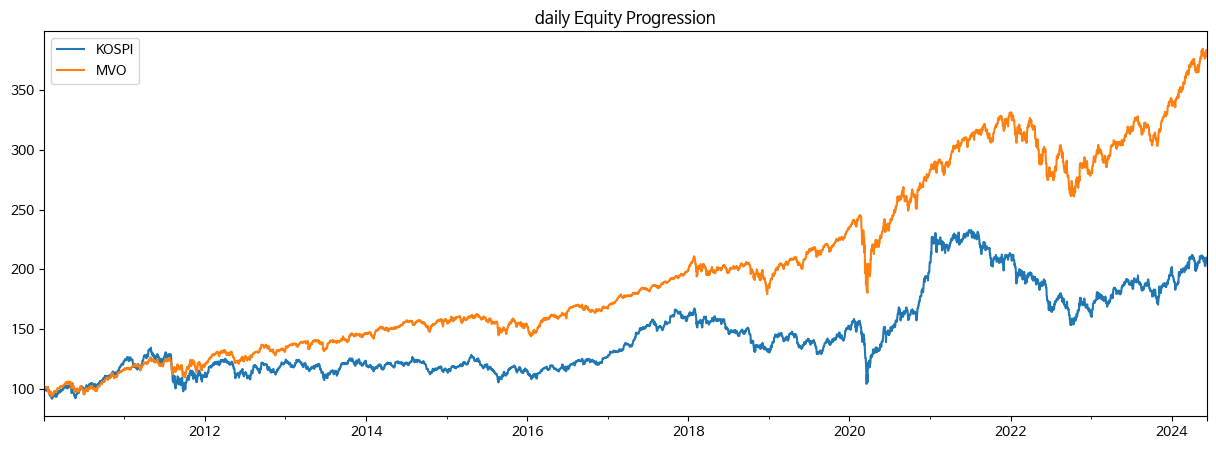

In [130]:
results.plot(freq='d');

In [131]:
results.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,KOSPI,MVO
total_return,1.097824,2.815645
cagr,0.052701,0.097273
daily_vol,0.16803,0.125443
max_drawdown,-0.378046,-0.265348
calmar,0.139405,0.366586
daily_sharpe,0.389967,0.803663


## Validation

In [136]:
s = ['069500',
'379800',
'411060']
{k:v for k,v in names.items() if k in s}

{'069500': 'KODEX 200', '379800': 'KODEX 미국S&P500TR', '411060': 'ACE KRX금현물'}

In [142]:
wts = [0.1, 0.7, 0.2]
wts = dict(zip(s, wts))
df = df_candi[s].dropna()

strategy = bt.Strategy('MVO', [
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(**wts),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])
bt1 =  bt.Backtest(strategy, df)

In [144]:
results = bt.run(bt0, bt1)

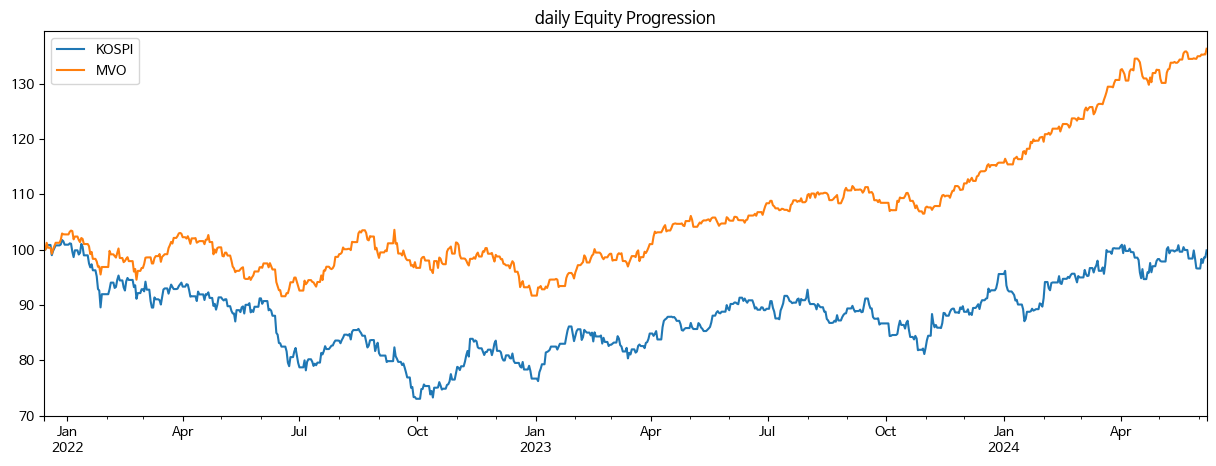

In [145]:
results.plot(freq='d');

In [146]:
results.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,KOSPI,MVO
total_return,-0.001226,0.363384
cagr,-0.000495,0.133107
daily_vol,0.175961,0.118219
max_drawdown,-0.282209,-0.11487
calmar,-0.001753,1.158756
daily_sharpe,0.084787,1.184944
